In [19]:
# drive接続
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# ファイル取得
import pandas as pd
import numpy as np
pd.options.display
# train = pd.read_csv('/content/drive/MyDrive/SMFG/train.csv', index_col=0) # 学習用データ
# test = pd.read_csv('/content/drive/MyDrive/SMFG/test.csv', index_col=0) # 学習用データ   # 評価用データ
sample_submit = pd.read_csv('/content/drive/MyDrive/SMFG/sample_submission.csv', index_col=0, header=None) # 応募用サンプルファイル

In [21]:
# # 'zip_city'と'boroname'の組み合わせを作成
# train['combined_address'] = train['zip_city'] + ', ' + train['boroname']

# # ユニークな組み合わせを抽出
# unique_addresses = train[['zip_city', 'boroname']].drop_duplicates()
# unique_addresses['combined_address'] = unique_addresses['zip_city'] + ', ' + unique_addresses['boroname']

# print(len(unique_addresses))
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

# # ジオコーディングの実行
# geolocator = Nominatim(user_agent="smbc_feature_monaou")
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# unique_addresses['location'] = unique_addresses['combined_address'].apply(lambda addr: geocode(addr))
# unique_addresses['latitude'] = unique_addresses['location'].apply(lambda loc: loc.latitude if loc else None)
# unique_addresses['longitude'] = unique_addresses['location'].apply(lambda loc: loc.longitude if loc else None)

# # 元のデータフレームにジオコーディング結果をマージ
# train = pd.merge(train, unique_addresses[['combined_address', 'latitude', 'longitude']], on='combined_address', how='left')
# train.to_csv('input/fixed_train.csv')
train = pd.read_csv('/content/drive/MyDrive/SMFG/fixed_train.csv', index_col=0) # 学習用データ
test = pd.read_csv('/content/drive/MyDrive/SMFG/fixed_test.csv', index_col=0) # 評価用データ

In [22]:
import pandas as pd
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.metrics.pairwise import haversine_distances
from math import radians

import pandas as pd
import re

def split_text_into_binary_columns(df, column_name, mode=0):
    # ワンホットエンコーディング用の新しい列を格納する辞書
    new_columns = {}

    if mode == 0:
        # ユニークな値を取得し、それぞれの値に対してバイナリ列を作成
        unique_values = train[column_name].unique()
        for value in unique_values:
            new_columns[f'{column_name}_{value}_oh'] = df[column_name].apply(lambda x: 1 if x == value else 0)
    elif mode == 1:
        # ラベルエンコーディングの実装
        unique_values = train[column_name].unique()
        value_to_int = {value: i for i, value in enumerate(unique_values)}
        df[f'{column_name}_encoded'] = df[column_name].map(value_to_int)

    else:
        # 正規表現の選択
        if column_name == 'problems':
            regex_pattern = '[A-Z][^A-Z]*'
        elif column_name in ['spc_common', 'spc_latin']:
            regex_pattern = r'\b\w+\b'
        elif column_name == 'nta_name':
            regex_pattern = r'\b\w+\b'

        # 全ての可能な単語を含むセットを作成
        all_words = set()
        for text in train[column_name]:
            if column_name == 'nta_name':
                text = text.replace('-', ' ')  # ハイフンを削除
            words = re.findall(regex_pattern, text)
            all_words.update(words)

        # 各単語の存在を示す列を作成
        for word in all_words:
            new_columns[f'{column_name}_{word}'] = df[column_name].apply(lambda x: 1 if word in x else 0)

    # Null以外の単語の総数をカウントする列を追加
    if mode == 2:
        df[f'{column_name}_total'] = df[column_name].apply(lambda x: 0 if x == 'Null' else len(re.findall(regex_pattern, x)))

    # 新しい列をDataFrameに結合
    df = pd.concat([df, pd.DataFrame(new_columns)], axis=1)

    return df

def calculate_top_distances(df, n_top=5):
    # ユニークな地点のセットを作成
    unique_points = df[['latitude', 'longitude']].drop_duplicates()
    unique_points['coords'] = list(zip(unique_points['latitude'], unique_points['longitude']))

    # 地球上の2点間の距離を計算する関数
    def calculate_distances(coord1, coord2):
        # 緯度経度をラジアンに変換
        coord1_rad = [radians(_) for _ in coord1]
        coord2_rad = [radians(_) for _ in coord2]
        return haversine_distances([coord1_rad, coord2_rad])[0][1] * 6371000/1000  # km単位

    # 各地点から他の地点への距離を計算
    distances = {}
    for i, row in unique_points.iterrows():
        distances[row['coords']] = unique_points['coords'].apply(lambda x: calculate_distances(row['coords'], x) if x != row['coords'] else np.inf)

    # 最も近い上位5つの地点までの距離を取得
    top_distances = pd.DataFrame(distances).apply(lambda x: sorted(x)[:n_top], axis=0).transpose()
    top_distances.columns = [f'geo_top_distance_{i+1}' for i in range(n_top)]

    # 元のデータフレームに結合
    df = df.merge(top_distances, left_on=['latitude', 'longitude'], right_index=True, how='left')

    return df

def create_dbh_features(df, add_feature_cols):
    new_features = {}

    for col in add_feature_cols:
        group = df.groupby(col)['tree_dbh']
        new_features[f'tree_dbh_{col}_max'] = group.transform('max')
        new_features[f'tree_dbh_{col}_min'] = group.transform('min')
        new_features[f'tree_dbh_{col}_25th'] = group.transform(lambda x: x.quantile(0.25))
        new_features[f'tree_dbh_{col}_median'] = group.transform('median')
        new_features[f'tree_dbh_{col}_75th'] = group.transform(lambda x: x.quantile(0.75))

    # Create a new DataFrame and concatenate it
    new_features_df = pd.DataFrame(new_features)
    df = pd.concat([df, new_features_df], axis=1)

    return df

def create_combination_features(df, add_feature_cols):
    new_features = {}

    for i, col1 in enumerate(add_feature_cols):
        for col2 in add_feature_cols[i+1:]:
            if np.issubdtype(df[col1].dtype, np.number) and np.issubdtype(df[col2].dtype, np.number):
                new_features[f'combination_{col1}_and_{col2}'] = df[col1] & df[col2]
                new_features[f'combination_{col1}_or_{col2}'] = df[col1] | df[col2]
                new_features[f'combination_{col1}_xor_{col2}'] = df[col1] ^ df[col2]

    # 新しい特徴量のDataFrameを作成して結合
    new_features_df = pd.DataFrame(new_features)
    df = pd.concat([df, new_features_df], axis=1)

    return df


def create_features(df):
    # 共通処理
    df.fillna('Null', inplace=True)
    df['tree_dbh'] = np.log(df['tree_dbh'].replace(0, np.nan))
    # df['bool_problems'] = df['problems'].apply(lambda x: 0 if x == 'Null' else 1)

    # 日付関連の特徴量
    df['created_date'] = pd.to_datetime(df['created_at'])
    df['unixtime'] = df['created_date'].apply(lambda x: x.timestamp())  # Unix 時間への変換
    # Unixtimeのビン分割
    df['unixtime_binned'] = pd.cut(df['unixtime'], bins=100, labels=False)

    # df['created_year'] = df['created_date'].dt.year
    # df['created_month'] = df['created_date'].dt.month
    # df['created_day'] = df['created_date'].dt.day
    # df['created_weekday'] = df['created_date'].dt.weekday
    # df['created_weekofyear'] = df['created_date'].dt.isocalendar().week

    df = split_text_into_binary_columns(df, 'problems', 1)
    df = split_text_into_binary_columns(df, 'problems', 2)
    df = split_text_into_binary_columns(df, 'spc_common', 1)
    df = split_text_into_binary_columns(df, 'spc_common', 2)
    df = split_text_into_binary_columns(df, 'spc_latin', 1)
    # df = split_text_into_binary_columns(df, 'spc_latin', 2)
    df = split_text_into_binary_columns(df, 'nta_name', 1)
    df = split_text_into_binary_columns(df, 'curb_loc', 0)
    df = split_text_into_binary_columns(df, 'sidewalk', 0)
    df = split_text_into_binary_columns(df, 'steward', 0)
    df = split_text_into_binary_columns(df, 'guards', 0)
    df = split_text_into_binary_columns(df, 'user_type', 0)

    return df.drop(['created_date'], axis=1)  # 'created_date'は削除

In [23]:
# データセットへの適用
train = create_features(train)
test = create_features(test)

# 特徴量の選択
combination_cols = []
combination_cols += [col for col in train.columns if col.startswith('problems_') and '_encoded' not in col and '_total' not in col]
combination_cols += [col for col in train.columns if col.startswith('curb_loc_') and '_encoded' not in col and '_total' not in col]
combination_cols += [col for col in train.columns if col.startswith('sidewalk_') and '_encoded' not in col and '_total' not in col]
combination_cols += [col for col in train.columns if col.startswith('guards_') and '_encoded' not in col and '_total' not in col]
combination_cols += [col for col in train.columns if col.startswith('user_type_') and '_encoded' not in col and '_total' not in col]

train = create_combination_features(train, combination_cols)
test = create_combination_features(test, combination_cols)

add_feature_cols = ['latitude', 'longitude']
add_feature_cols += [col for col in train.columns if col.startswith('problems_')]
add_feature_cols += [col for col in train.columns if col.startswith('spc_common_')]
# add_feature_cols += [col for col in train.columns if col.startswith('spc_latin_')]
# add_feature_cols += [col for col in train.columns if col.startswith('nta_name_')]
add_feature_cols += [col for col in train.columns if col.startswith('curb_loc_')]
add_feature_cols += [col for col in train.columns if col.startswith('sidewalk_')]
add_feature_cols += [col for col in train.columns if col.startswith('steward_')]
add_feature_cols += [col for col in train.columns if col.startswith('guards_')]
add_feature_cols += [col for col in train.columns if col.startswith('user_type_')]
# add_feature_cols += [col for col in train.columns if col.startswith('combination_')]

train = create_dbh_features(train, add_feature_cols)
test = create_dbh_features(test, add_feature_cols)


# 特徴量の選択
selected_cols = []
selected_cols += [col for col in train.columns if col.startswith('problems_')]
selected_cols += [col for col in train.columns if col.startswith('curb_loc_')]
selected_cols += [col for col in train.columns if col.startswith('sidewalk_')]
selected_cols += [col for col in train.columns if col.startswith('guards_')]
selected_cols += [col for col in train.columns if col.startswith('user_type_')]
selected_cols += [
    'tree_dbh',  # 'unixtime_binned',#'bool_problems',
    'borocode', 'boro_ct', 'cb_num', 'st_senate', 'st_assem', 'cncldist',
    'latitude', 'longitude'
]
selected_cols += [col for col in train.columns if col.startswith('combination_')]
# selected_cols += [col for col in train.columns if col.startswith('tree_dbh_')]
selected_cols += [col for col in train.columns if col.startswith('spc_common_')]
selected_cols += [col for col in train.columns if col.startswith('spc_latin_')]
selected_cols += [col for col in train.columns if col.startswith('nta_name_')]
selected_cols += [col for col in train.columns if col.startswith('geo_')]

# エンコーディングされた特徴量と他の特徴量を結合
X = train[selected_cols]
test = test[selected_cols]

# 目的変数と特徴量を分離
y = train['health']


In [24]:
print(train['spc_common'].unique())

['English oak' 'crimson king maple' 'honeylocust' 'London planetree'
 'Amur cork tree' 'littleleaf linden' 'cherry' 'Siberian elm'
 'Norway maple' 'Japanese zelkova' 'green ash' 'American elm'
 'Kentucky coffeetree' 'Amur maackia' 'silver linden' "Schumard's oak"
 'pin oak' 'red horse chestnut' 'American hornbeam' 'silver maple'
 'ginkgo' 'Callery pear' 'Turkish hazelnut' 'Amur maple' 'American linden'
 'catalpa' 'Sophora' 'katsura tree' 'maple' 'American hophornbeam'
 'bur oak' 'cockspur hawthorn' 'Japanese tree lilac' 'eastern hemlock'
 'sassafras' 'sawtooth oak' 'willow oak' 'black oak' 'eastern redbud'
 'sweetgum' 'scarlet oak' 'purple-leaf plum' "'Schubert' chokecherry"
 'Chinese elm' 'dawn redwood' 'Chinese fringetree' 'American beech'
 'red maple' 'tartar maple' 'sycamore maple' 'swamp white oak' 'holly'
 'northern red oak' 'ash' 'Ohio buckeye' 'Cornelian cherry' 'black walnut'
 'crab apple' 'hawthorn' 'silver birch' 'black locust' 'hedge maple'
 'Persian ironwood' 'Norway spruc

In [25]:
print(train['unixtime_binned'].unique())

[ 8 97 23 70 79 16 31 75 85 29 32 25 15 11 20  1 91 56 10 35 18 95 88 26
  6 28 24  7 30 27 80 13 36 39 86 81 34 78  3 72 92 84 12 33 94 21 96 38
 93  5  4 59 82 19 41 17 14 22 67 40 44 73 87  9 77  2 89 37 69 83  0 68
 42 71 98 60 54 90 76 66 52 65 64 45 74 57 61 63 58 43 47 48 53 51 49 62
 50 99 46 55]


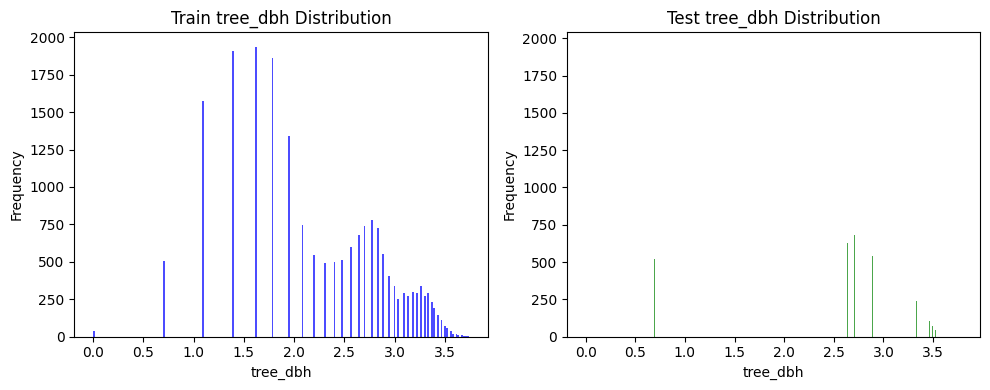

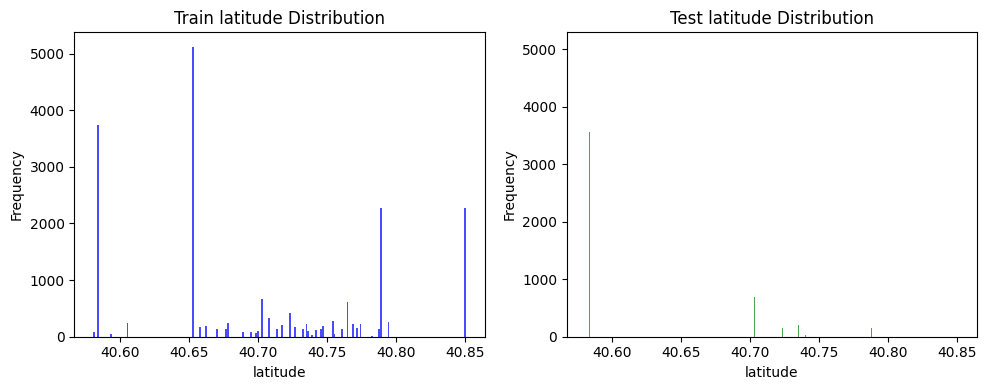

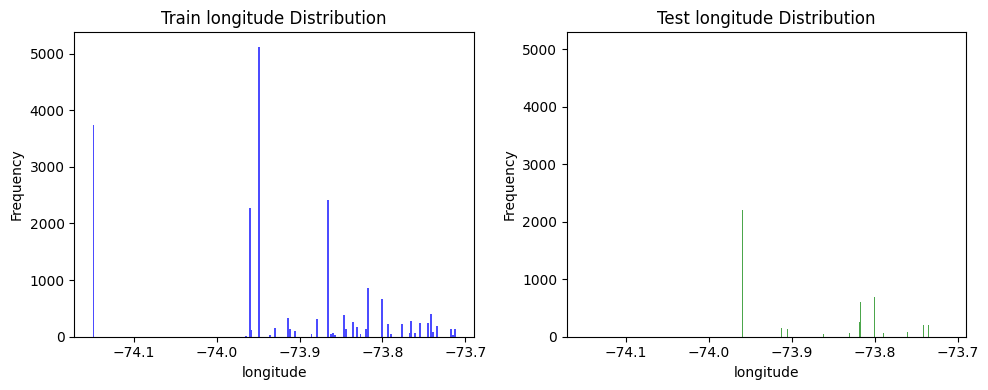

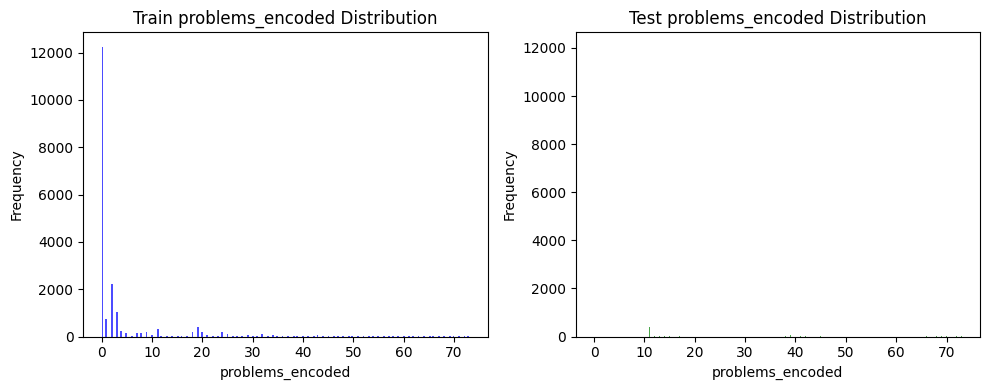

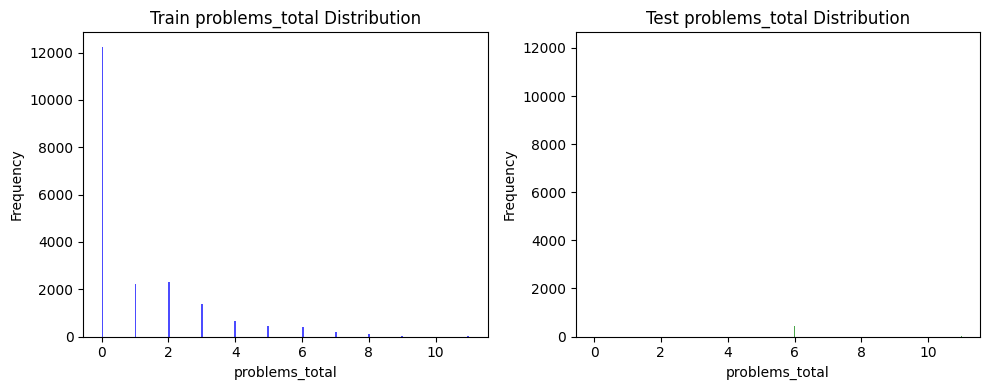

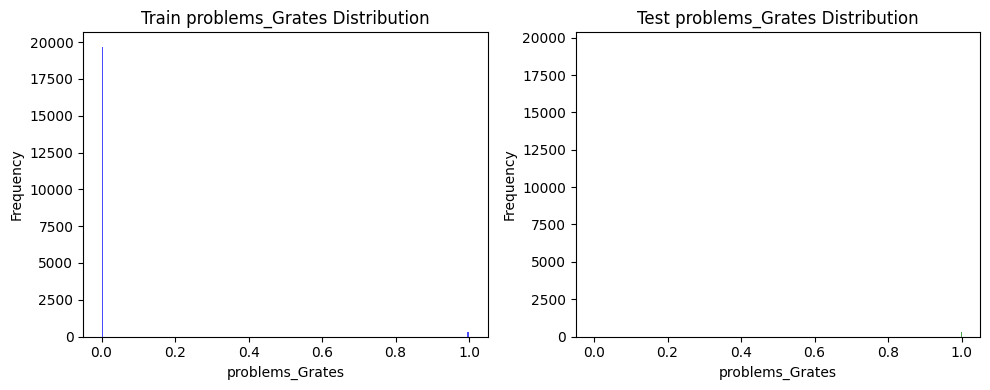

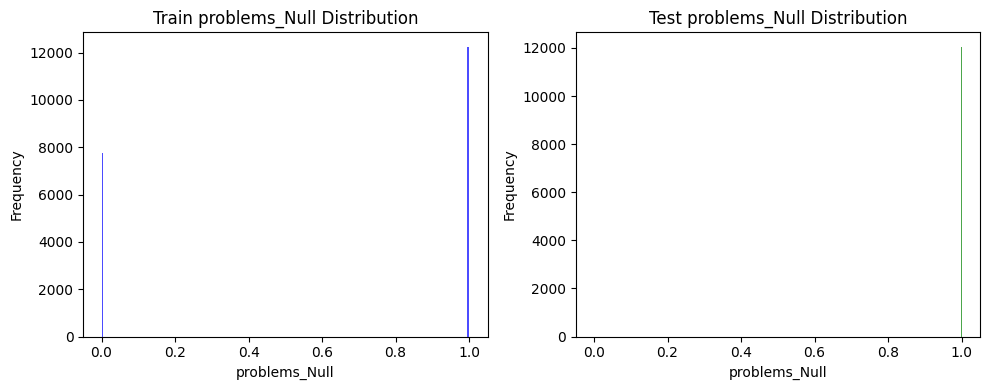

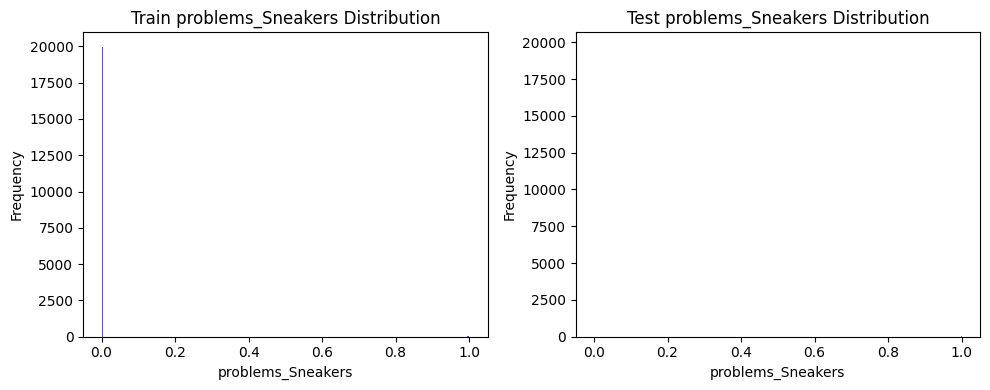

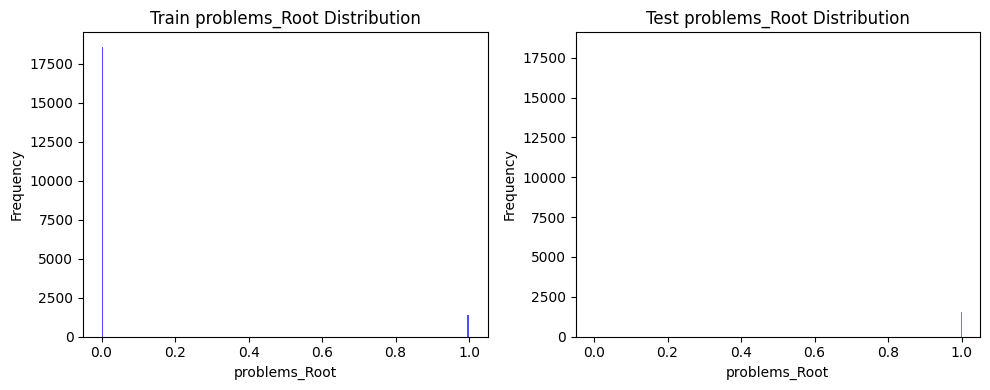

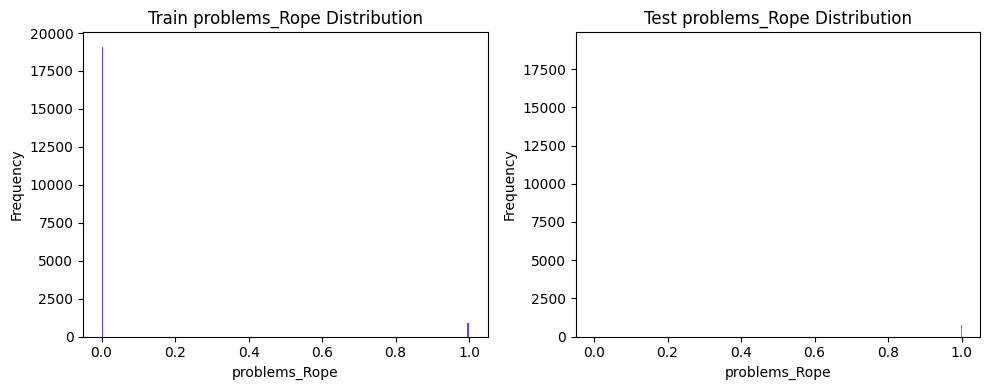

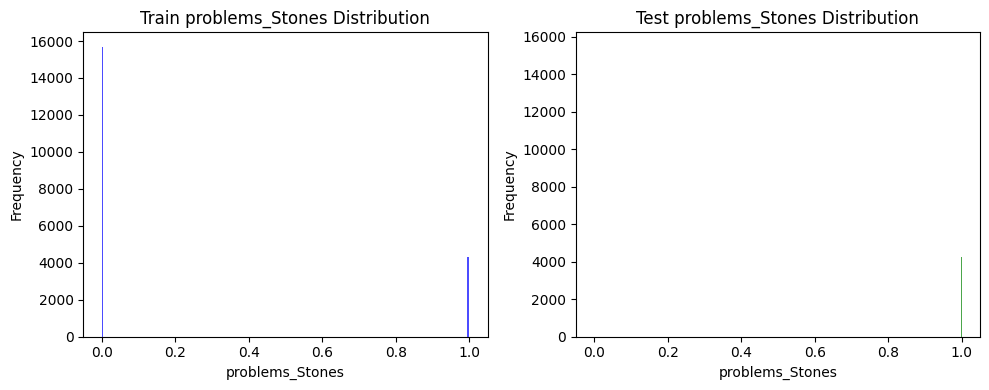

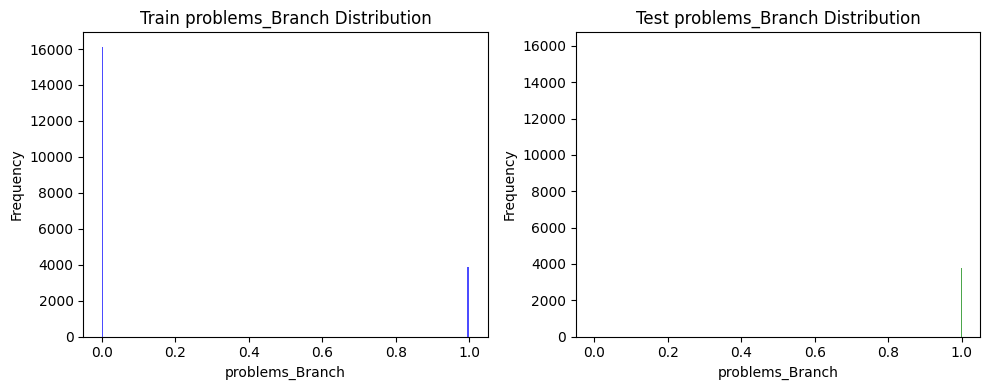

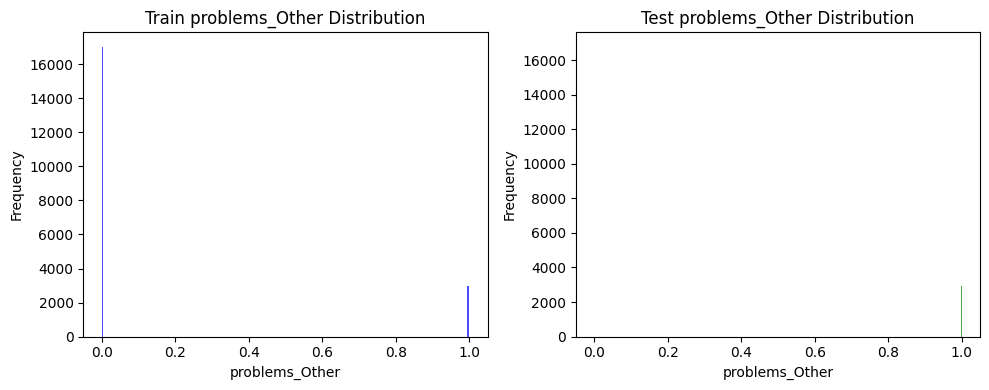

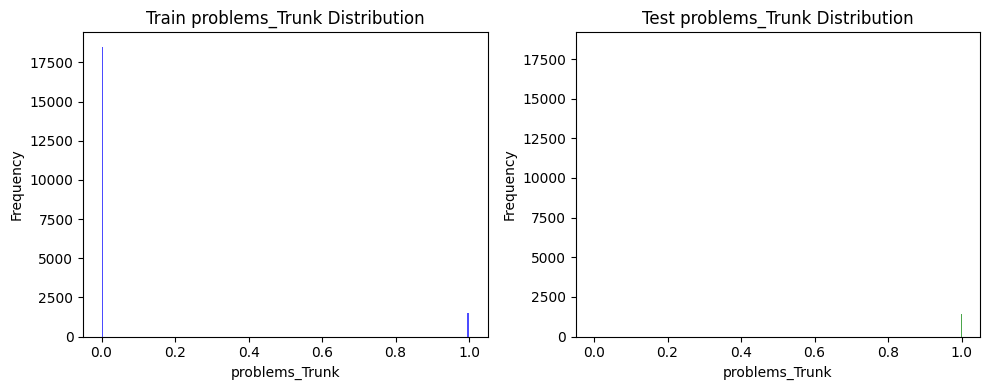

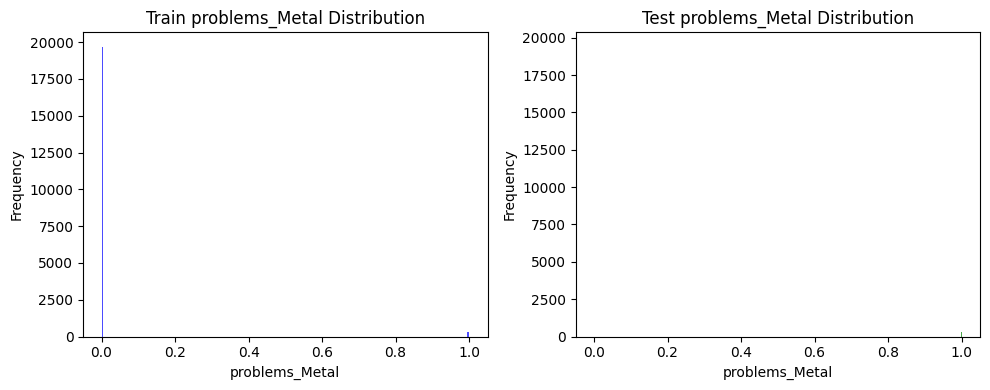

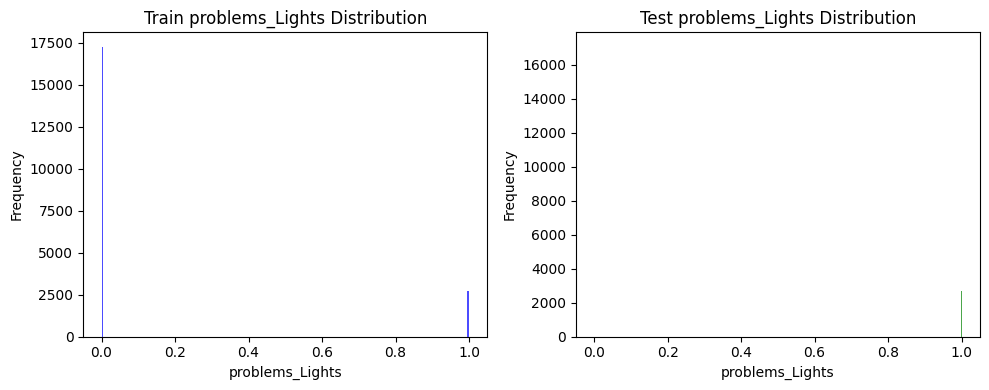

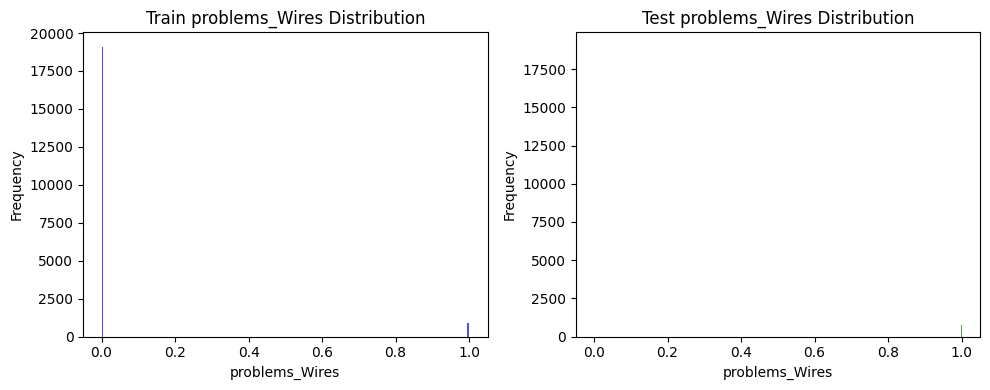

In [26]:
import matplotlib.pyplot as plt

def plot_feature_distribution(train, test, feature):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(train[feature], bins=200, alpha=0.7, color='blue')
    plt.title(f'Train {feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(test[feature], bins=2000, alpha=0.7, color='green')
    plt.title(f'Test {feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

viewer_cols = [
    'tree_dbh',  #'unixtime','bool_problems','created_month',
    #'borocode', 'boro_ct', 'cb_num', 'st_senate', 'st_assem', 'cncldist',
      'latitude', 'longitude'
]
viewer_cols += [col for col in train.columns if col.startswith('problems_')]
# 特徴量の分布をプロット
for col in viewer_cols:
    plot_feature_distribution(train, test, col)

In [27]:
for i in X.columns:
  print(f"i {i}")

i problems_encoded
i problems_total
i problems_Grates
i problems_Null
i problems_Sneakers
i problems_Root
i problems_Rope
i problems_Stones
i problems_Branch
i problems_Other
i problems_Trunk
i problems_Metal
i problems_Lights
i problems_Wires
i curb_loc_OnCurb_oh
i curb_loc_OffsetFromCurb_oh
i sidewalk_Damage_oh
i sidewalk_NoDamage_oh
i guards_Null_oh
i guards_Helpful_oh
i guards_Harmful_oh
i guards_Unsure_oh
i user_type_Volunteer_oh
i user_type_NYC Parks Staff_oh
i user_type_TreesCount Staff_oh
i tree_dbh
i borocode
i boro_ct
i cb_num
i st_senate
i st_assem
i cncldist
i latitude
i longitude
i combination_problems_Grates_and_problems_Null
i combination_problems_Grates_or_problems_Null
i combination_problems_Grates_xor_problems_Null
i combination_problems_Grates_and_problems_Sneakers
i combination_problems_Grates_or_problems_Sneakers
i combination_problems_Grates_xor_problems_Sneakers
i combination_problems_Grates_and_problems_Root
i combination_problems_Grates_or_problems_Root
i combi

In [28]:
X

,problems_encoded,problems_total,problems_Grates,problems_Null,problems_Sneakers,problems_Root,problems_Rope,problems_Stones,problems_Branch,problems_Other,...,spc_common_golden,spc_common_swamp,spc_common_Sophora,spc_common_sweetgum,spc_common_purple,spc_common_pine,spc_common_dawn,spc_common_Callery,spc_latin_encoded,nta_name_encoded
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,1,3,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
4,2,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,96,91
19980,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,16
19981,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23
19982,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,59


In [29]:

# import seaborn as sns
# # 箱ひげ図および棒グラフの描画
# for col in selected_cols:
#     if train[col].nunique() > 10:  # 連続値または多様な値を持つ離散値に対して描画
#         plt.figure(figsize=(10, 6))
#         sns.boxplot(x=y, y=train[col])
#         plt.title(f"Boxplot of {col} by Health")
#         plt.xlabel("Health")
#         plt.ylabel(col)
#         plt.show()
#     else:  # カテゴリ変数の場合
#         # 各health値における割合の計算
#         proportion_data = train.groupby('health')[col].value_counts(normalize=True).unstack().fillna(0)

#         # カウントと割合のグラフを横並びで表示
#         fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#         # カウントグラフ
#         sns.countplot(x=col, hue=y, data=train, ax=axes[0])
#         axes[0].set_title(f"Count of {col} by Health")
#         axes[0].set_ylabel('Count')
#         axes[0].set_xlabel(col)

#         # 割合グラフ
#         proportion_data.plot(kind='bar', stacked=True, ax=axes[1])
#         axes[1].set_title(f"Proportion of {col} by Health")
#         axes[1].set_ylabel('Proportion')
#         axes[1].set_xlabel('Health')
#         plt.show()

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# モデルごとのスコアを表示する関数
def plot_model_scores(scores, model_names, title, metrics):
    plt.figure(figsize=(10, 6))
    scores_array = np.array(scores).T
    for i, metric in enumerate(metrics):
      if metric == 'F1 Score':
        bars = plt.bar(np.arange(len(scores)) + i * 0.2, scores_array[i], width=0.2, label=metric)
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')  # バーの中央上にスコアを表示

    plt.xlabel('Model')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(np.arange(len(scores)) + 0.2, model_names)
    plt.legend()
    plt.tight_layout()
    plt.show()

# モデルの比較スコアを表示する関数
def plot_comparison_scores(scores_list, labels, title, metrics):
    plt.figure(figsize=(10, 6))
    index = np.arange(len(metrics))
    bar_width = 0.35

    for i, scores in enumerate(scores_list):
        bars = plt.bar(index + i * bar_width, scores, bar_width, label=labels[i])
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')  # バーの中央上にスコアを表示

    plt.xlabel('Metric')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(index + bar_width / 2, metrics)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 使用例
# plot_model_scores(...)
# plot_comparison_scores(...)


In [31]:
parameter_combinations = [
    {
        'max_depth': 50,
        'num_leaves': 256,
        'feature_fraction': 1.0,
    },
    {
        'max_depth': 50,
        'num_leaves': 256,
        'feature_fraction': 0.9,
    },
    {
        'max_depth': 50,
        'num_leaves': 256,
        'feature_fraction': 0.8,
    },
    {
        'max_depth': 40,
        'num_leaves': 192,
        'feature_fraction': 1.0,
    },
    {
        'max_depth': 40,
        'num_leaves': 192,
        'feature_fraction': 0.9,
    },
    {
        'max_depth': 40,
        'num_leaves': 192,
        'feature_fraction': 0.8,
    },
    {
        'max_depth': 30,
        'num_leaves': 128,
        'feature_fraction': 1.0,
    },
    {
        'max_depth': 30,
        'num_leaves': 128,
        'feature_fraction': 0.9,
    },
    {
        'max_depth': 30,
        'num_leaves': 128,
        'feature_fraction': 0.8,
    },
    {
        'max_depth': 20,
        'num_leaves': 40,
        'feature_fraction': 1.0,
    },
    {
        'max_depth': 20,
        'num_leaves': 40,
        'feature_fraction': 0.9,
    },
    {
        'max_depth': 20,
        'num_leaves': 40,
        'feature_fraction': 0.8,
    },
]

In [32]:
!pip install optuna
!pip install catboost
!pip install -U ITMO_FS
# import optuna
def focal_loss_lgb(preds, train_data, alpha=0.75, gamma=2.0):
    # 正しいラベルを取得
    labels = train_data.get_label().astype(int)
    num_labels = len(np.unique(labels))

    # 予測された確率を[データ点数, クラス数]の形状に変換
    reshaped_preds = preds.reshape(len(labels), num_labels, order='F')

    # one-hot encoding形式に変換
    one_hot_labels = np.eye(num_labels)[labels]

    # 予測確率を安定させるためにソフトマックスの計算を修正
    max_preds = reshaped_preds.max(axis=1, keepdims=True)
    softmax_preds = np.exp(reshaped_preds - max_preds) / np.exp(reshaped_preds - max_preds).sum(axis=1, keepdims=True)

    # Focal Lossの勾配とヘシアンを計算
    grad = (1 - softmax_preds) ** gamma * (softmax_preds - one_hot_labels)
    hess = gamma * (1 - softmax_preds) ** (gamma - 1) * softmax_preds * (one_hot_labels - softmax_preds) * (1 - 2 * softmax_preds)

    # alphaによる調整
    grad *= alpha * one_hot_labels + (1 - alpha) * (1 - one_hot_labels)
    hess *= alpha * one_hot_labels + (1 - alpha) * (1 - one_hot_labels)

    return grad.flatten('F'), hess.flatten('F')


def lgb_f1_score(y_pred, y_true):
    labels = y_true.get_label()
    preds = y_pred.argmax(axis=1)
    f1 = f1_score(labels, preds, average='macro')
    return 'f1', f1, True  # Trueは高い方が良いことを示す

In [33]:
from pickle import FALSE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
from lightgbm.callback import early_stopping
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from ITMO_FS.filters.multivariate import MRMR
from sklearn.preprocessing import KBinsDiscretizer
from xgboost import XGBClassifier


RANDOM_STATE = 4
n_split = 5
n_select = 1
NUM_TRIALS = 1  #5  # Fold Splitの試行回数
IS_MINORITY_MODEL = False
IS_MORE_MINORITY_MODEL = False
IS_TARGET_ENCORDING = False

base_model_scores = []
meta_model_scores = []
metrics = ['Accuracy', 'Recall', 'F1 Score']
base_trained_models = []
pre_trained_models = [[] for _ in range(n_split)]

for trial in range(NUM_TRIALS):
    kf = KFold(n_splits=n_split, shuffle=True, random_state=RANDOM_STATE+trial)
    skf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=RANDOM_STATE+trial)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #ターゲットエンコーディングの実装
        if IS_TARGET_ENCORDING:
            print("test")

        # クラスの重みを計算
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        scale_pos_weight = len([y for y in y_train if y != 1]) / len([y for y in y_train if y == 1])

        weights = {i: w for i, w in enumerate(class_weights)}
        train_weights = np.array([weights[t] for t in y_train])

        if IS_MINORITY_MODEL:
            # =========================================================================================
            print("IS_MINORITY_MODEL")
            # 少数ラベル専用モデルのデータ前処理
            y_train_minority = y_train.apply(lambda x: 1 if x == 2 or x == 0 else 0)
            y_val_minority = y_val.apply(lambda x: 1 if x == 2 or x == 0 else 0)
            # クラスの重みを計算して辞書形式で指定
            class_weights_minority = compute_class_weight('balanced', classes=np.unique(y_train_minority), y=y_train_minority)
            class_weights_minority_dict = {i: weight for i, weight in enumerate(class_weights_minority)}
            scale_pos_weight_minority = len([y for y in y_train_minority if y != 1]) / len([y for y in y_train_minority if y == 1])

            # 少数ラベル専用モデルのデータ前処理
            minority_model = [
                # XGBClassifier(scale_pos_weight=scale_pos_weight_minority, random_state=RANDOM_STATE, verbosity=0),
                # lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE),
                LogisticRegression(class_weight=class_weights_minority_dict, penalty='l2', random_state=RANDOM_STATE, max_iter=1000),
                CatBoostClassifier(scale_pos_weight=scale_pos_weight_minority,random_seed = RANDOM_STATE, verbose = 0),
                RandomForestClassifier(class_weight=class_weights_minority_dict,random_state = RANDOM_STATE),
                #XGBClassifier(random_state=RANDOM_STATE, verbosity=0),
                #lgb.LGBMClassifier(random_state=RANDOM_STATE),
                #LogisticRegression(penalty='l2', random_state=RANDOM_STATE, max_iter=1000),
                # CatBoostClassifier(random_seed = RANDOM_STATE, verbose = 0),
                # RandomForestClassifier(random_state = RANDOM_STATE)
            ]

            # 少数ラベル専用モデルの訓練
            add_features = []
            for i, model in enumerate(minority_model):
                model.fit(X_train, y_train_minority)

                # 少数ラベル専用モデルの予測
                train_minority_preds = model.predict_proba(X_train)  # 少数ラベルの確率
                val_minority_preds = model.predict_proba(X_val)  # 少数ラベルの確率

                # 最も確率が高いクラスを選択
                val_minority_preds_labels = np.argmax(val_minority_preds, axis=1)

                f1 = f1_score(y_val_minority, val_minority_preds_labels, average='macro')
                print(f"{i} model : f1 :{f1}")

                # 少数ラベル専用モデルの保存
                add_features.append((train_minority_preds[:, 0], train_minority_preds[:, 1], val_minority_preds[:, 0], val_minority_preds[:, 1]))
                pre_trained_models[i].append(model)

            # 予測結果を特徴量として追加
            for i, feat in enumerate(add_features):
                X_train.loc[:, f'minority_pred_{i}_0'] = feat[0]
                X_train.loc[:, f'minority_pred_{i}_1'] = feat[1]
                X_val.loc[:, f'minority_pred_{i}_0'] = feat[2]
                X_val.loc[:, f'minority_pred_{i}_1'] = feat[3]
        # if IS_MORE_MINORITY_MODEL:
        #     # =========================================================================================
        #     print("IS_MORE_MINORITY_MODEL")
        #     # 少数ラベル専用モデルのデータ前処理
        #     minority_indices_train = y_train[y_train != 1].index
        #     minority_indices_val = y_val[y_val != 1].index

        #     X_train_minority = X_train.loc[minority_indices_train]
        #     y_train_minority = y_train.loc[minority_indices_train]
        #     X_val_minority = X_val.loc[minority_indices_val]
        #     y_val_minority = y_val.loc[minority_indices_val]

        #     # 少数ラベル専用モデルのデータ前処理
        #     y_train_minority = y_train_minority.apply(lambda x: 1 if x == 2 else 0)
        #     y_val_minority = y_val_minority.apply(lambda x: 1 if x == 2 else 0)
        #     # クラスの重みを計算して辞書形式で指定
        #     class_weights_minority = compute_class_weight('balanced', classes=np.unique(y_train_minority), y=y_train_minority)
        #     class_weights_minority_dict = {i: weight for i, weight in enumerate(class_weights_minority)}
        #     scale_pos_weight_minority = len([y for y in y_train_minority if y != 1]) / len([y for y in y_train_minority if y == 1])

        #     # 少数ラベル専用モデルのデータ前処理
        #     minority_model = [
        #         # XGBClassifier(scale_pos_weight=scale_pos_weight_minority, random_state=RANDOM_STATE, verbosity=0),
        #         # lgb.LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE),
        #         # LogisticRegression(class_weight=class_weights_minority_dict, penalty='l2', random_state=RANDOM_STATE, max_iter=1000),
        #         CatBoostClassifier(scale_pos_weight=scale_pos_weight_minority,random_seed = RANDOM_STATE, verbose = 0),
        #         RandomForestClassifier(class_weight=class_weights_minority_dict,random_state = RANDOM_STATE),
        #         #XGBClassifier(random_state=RANDOM_STATE, verbosity=0),
        #         #lgb.LGBMClassifier(random_state=RANDOM_STATE),
        #         #LogisticRegression(penalty='l2', random_state=RANDOM_STATE, max_iter=1000),
        #         # CatBoostClassifier(random_seed = RANDOM_STATE, verbose = 0),
        #         # RandomForestClassifier(random_state = RANDOM_STATE)
        #     ]

        #     # 少数ラベル専用モデルの訓練
        #     add_features = []
        #     for i, model in enumerate(minority_model):
        #         model.fit(X_train_minority, y_train_minority)

        #         # 少数ラベル専用モデルの予測
        #         train_minority_preds = model.predict_proba(X_train)  # 少数ラベルの確率
        #         val_minority_preds_more = model.predict_proba(X_val_minority)  # 少数ラベルの確率
        #         val_minority_preds = model.predict_proba(X_val)  # 少数ラベルの確率

        #         # 最も確率が高いクラスを選択
        #         val_minority_preds_labels = np.argmax(val_minority_preds_more, axis=1)

        #         f1 = f1_score(y_val_minority, val_minority_preds_labels, average='macro')
        #         print(f"{i} model : f1 :{f1}")

        #         # 少数ラベル専用モデルの保存
        #         add_features.append((train_minority_preds[:, 0], train_minority_preds[:, 1], val_minority_preds[:, 0], val_minority_preds[:, 1]))

        #     # 予測結果を特徴量として追加
        #     for i, feat in enumerate(add_features):
        #         X_train.loc[:, f'more_minority_pred_{i}_0'] = feat[0]
        #         X_train.loc[:, f'more_minority_pred_{i}_1'] = feat[1]
        #         X_val.loc[:, f'more_minority_pred_{i}_0'] = feat[2]
        #         X_val.loc[:, f'more_minority_pred_{i}_1'] = feat[3]

        # =========================================================================================
        # データセットを LightGBM 形式に変換
        train_data = lgb.Dataset(X_train, label=y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, label=y_val)

        # ベースモデルの訓練
        model_scores = []
        for i, params in enumerate(parameter_combinations):
            print(f"{i}/{params}")
            params['random_state'] = RANDOM_STATE
            params['objective'] = 'multiclass'
            # params['objective'] = focal_loss_lgb
            params['num_class'] = 3
            params['boosting_type'] = 'gbdt'
            params['learning_rate'] = 0.05
            params['extra_trees'] = True

            model = lgb.train(
                params,
                train_data,
                valid_sets=[val_data],
                num_boost_round=2000,
                callbacks=[early_stopping(stopping_rounds=100)],
                feval=lgb_f1_score
            )

            # 予測値をクラスラベルに変換
            val_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
            val_pred = np.argmax(val_pred_proba, axis=1)

            acc = accuracy_score(y_val, val_pred)
            recall = recall_score(y_val, val_pred, average='macro')
            f1 = f1_score(y_val, val_pred, average='macro')

            model_scores.append((model, acc, recall, f1))
        # ベースモデルの評価
        top_3_models = sorted(model_scores, key=lambda x: x[3], reverse=True)[:n_select]

        # ベースモデルの評価結果をプロット
        plot_model_scores([score[1:] for score in top_3_models], [f'Top Model {i+1}' for i in range(n_select)],
                          'Performance of Top 3 Models', metrics)

        # 選択したモデルでデータを更新
        train_preds = np.array([]).reshape(len(X_train), 0) # 初期化#X_train
        val_preds = np.array([]).reshape(len(X_val), 0)
        # test_preds = np.array([]).reshape(len(test), 0)

        for model, acc, rec, f1 in top_3_models:
            base_model_scores.append((acc, rec, f1))
            base_trained_models.append(model)
            train_preds = np.hstack([train_preds, model.predict(X_train, num_iteration=model.best_iteration)])
            val_preds = np.hstack([val_preds, model.predict(X_val, num_iteration=model.best_iteration)])
            # test_preds = np.hstack([test_preds, model.predict(test, num_iteration=model.best_iteration)])

        # TOP1ベースモデルの特徴量の重要性の表示（LightGBMの場合）
        top_model = top_3_models[0][0]  # F1スコアが最も高いモデルを選択
        fig, ax = plt.subplots(figsize=(10 * 1.5, 6 * 1.5))  # グラフサイズを設定
        lgb.plot_importance(top_model, max_num_features=50, importance_type='gain', ax=ax)
        ax.set_title("Top 50 Feature Importance")
        ax.set_ylabel("Feature importance (gain)")
        plt.show()

        # TOP1ベースモデルの混同行列評価
        val_pred_proba = top_model.predict(X_val, num_iteration=top_model.best_iteration)
        val_pred = np.argmax(val_pred_proba, axis=1)
        f1 = f1_score(y_val, val_pred, average='macro')
        conf_matrix = confusion_matrix(y_val, val_pred)
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g')
        plt.title(f'Fold {fold+1} - Confusion Matrix of TOP Model {f1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()



        # CatBoost モデルのトレーニング
        # cat_params = {
        #     'class_weights': class_weights,  # クラスの重み
        #     'random_seed': RANDOM_STATE,  # 乱数シード
        #     'verbose': 20  # 出力の頻度
        # }
        # cat_model = CatBoostClassifier(**cat_params)
        # cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

        # cat_val_pred = cat_model.predict(X_val)

        # acc = accuracy_score(y_val, cat_val_pred)
        # recall = recall_score(y_val, cat_val_pred, average='macro')
        # f1 = f1_score(y_val, cat_val_pred, average='macro')

        # conf_matrix = confusion_matrix(y_val, cat_val_pred)
        # plt.figure(figsize=(6, 6))
        # sns.heatmap(conf_matrix, annot=True, fmt='g')
        # plt.title(f'Fold {fold+1} - cat_model Confusion Matrix of TOP Model {f1}')
        # plt.xlabel('Predicted')
        # plt.ylabel('Actual')
        # plt.show()

        # アンサンブル
        # ensenmble_pred_proba = (cat_val_pred_proba + val_pred_proba) / 2
        # ensenmble_val_pred = np.argmax(ensenmble_pred_proba, axis=1)

        # acc = accuracy_score(y_val, ensenmble_val_pred)
        # recall = recall_score(y_val, ensenmble_val_pred, average='macro')
        # f1 = f1_score(y_val, ensenmble_val_pred, average='macro')

        # conf_matrix = confusion_matrix(y_val, ensenmble_val_pred)
        # plt.figure(figsize=(6, 6))
        # sns.heatmap(conf_matrix, annot=True, fmt='g')
        # plt.title(f'Fold {fold+1} - cat_model Confusion Matrix of TOP Model {f1}')
        # plt.xlabel('Predicted')
        # plt.ylabel('Actual')
        # plt.show()

        # クラスの重みを計算
        # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        # weights_dict = {i: w for i, w in enumerate(class_weights)}

        # # メタモデルの訓練
        # meta_model = LogisticRegression(class_weight=weights_dict, random_state=RANDOM_STATE)
        # meta_model.fit(train_preds, y_train)
        # meta_val_preds = meta_model.predict(val_preds)  # 直接クラスラベルを予測

        # # メタモデルの評価
        # acc_meta = accuracy_score(y_val, meta_val_preds)
        # recall_meta = recall_score(y_val, meta_val_preds, average='macro')
        # f1_meta = f1_score(y_val, meta_val_preds, average='macro')
        # meta_model_scores.append((acc_meta, recall_meta, f1_meta))

        # # メタモデルの混同行列評価
        # conf_matrix = confusion_matrix(y_val, meta_val_preds)
        # plt.figure(figsize=(6, 6))
        # sns.heatmap(conf_matrix, annot=True, fmt='g')
        # plt.title(f'Fold {fold+1} - Confusion Matrix of Meta Model{acc_meta}/ {recall_meta}/{f1_meta}')
        # plt.xlabel('Predicted')
        # plt.ylabel('Actual')
        # plt.show()


    # ベースモデルとメタモデルの平均性能の計算
    avg_base_model_scores = np.mean(base_model_scores, axis=0)
    avg_meta_model_scores = np.mean(meta_model_scores, axis=0)

    # グラフの描画
    plot_comparison_scores([avg_base_model_scores, avg_meta_model_scores], ['Base Models', 'Meta Model'], 'Comparison of Average Performance', metrics)

Output hidden; open in https://colab.research.google.com to view.

check ensemble 5
Class Counts:
0     4306
1    14366
2     1030
dtype: int64


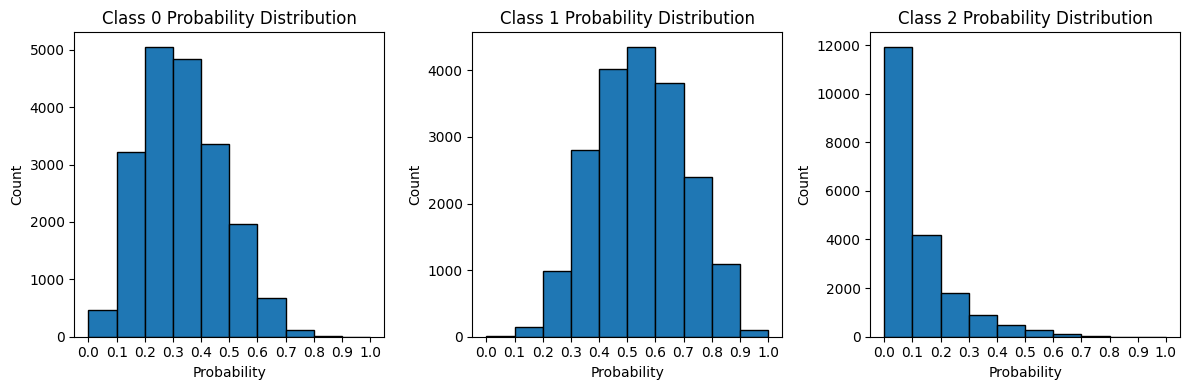

sample_submit finish=============


In [34]:
import pandas as pd

# テストデータに対する予測
predictions = np.zeros((test.shape[0], 3))
if IS_MINORITY_MODEL:
    mono_test = test.copy()
    for i in range(3):
      test.loc[:, f'minority_pred_{i}_0'] = 0
      test.loc[:, f'minority_pred_{i}_1'] = 0

    for n in range(n_split):
      models = pre_trained_models[n]
      add_features = []
      for i, model in enumerate(minority_model):
        # 少数ラベル専用モデルの予測
        test_minority_preds = model.predict_proba(mono_test)  # 少数ラベルの確率
        add_features.append((test_minority_preds[:, 0], test_minority_preds[:, 1]))

      # 予測結果を特徴量として追加
      for i, feat in enumerate(add_features):
        test[f'minority_pred_{i}_0'] = feat[0]
        test[f'minority_pred_{i}_1'] = feat[1]
      base_model = base_trained_models[n]
      predictions += base_model.predict(test, num_iteration=base_model.best_iteration)
    predictions /= len(base_trained_models)

else:
  for i, model in enumerate(base_trained_models):
      predictions += model.predict(test, num_iteration=model.best_iteration)
  predictions /= len(base_trained_models)

print("check ensemble", len(base_trained_models))

# 最も高い確率を持つクラスを選択
predicted_classes = np.argmax(predictions, axis=1)

# 各クラスの出現回数をカウント
class_counts = pd.Series(predicted_classes).value_counts().sort_index()

# 表形式で表示
print("Class Counts:")
print(class_counts)

# 各クラスごとの確率分布をヒストグラムで表示
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(12, 4))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.hist(predictions[:, i], bins=bins, edgecolor='black')
    plt.title(f'Class {i} Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.xticks(bins)

plt.tight_layout()
plt.show()

# 予測結果をDataFrameに保存
sample_submit[1] = predicted_classes
sample_submit.to_csv('/content/drive/MyDrive/SMFG/submit.csv', header=None)
print("sample_submit finish=============")

In [35]:
import pandas as pd
if IS_MINORITY_MODEL:


# テストデータに対する予測
predictions = np.zeros((test.shape[0], 3))
for model in base_trained_models:
    predictions += np.argmax(model.predict(test, num_iteration=model.best_iteration), axis=1)
predictions /= len(base_trained_models)

# 予測値を四捨五入してクラスに変換
predicted_classes = np.argmax(model.predict(test, num_iteration=model.best_iteration), axis=1)

# 各クラスの出現回数をカウント
class_counts = pd.Series(predicted_classes).value_counts().sort_index()

# 表形式で表示
print("Class Counts:")
print(class_counts)

# 予測結果をDataFrameに保存
sample_submit[1] = predicted_classes
sample_submit.to_csv('/content/drive/MyDrive/SMFG/submit_classcount.csv', header=None)


IndentationError: expected an indented block after 'if' statement on line 2 (<ipython-input-35-6e5a0790ab20>, line 6)

In [ ]:
# minority 0.3527 - 0.355
# normal 0.3533 - full feat
# normal 0.3547 - few feat mimority 0.3595
# normal 0.355 normalized dbh
# feat collect dbh

In [ ]:
# mino cat/rf 0.354
# mino cat/rf/xgbt 0.349
# mino lr/rf 0.3526 pre-0,1,2 0.3532
# mino cat/lr/rf 0.356 >> 0.349

In [ ]:
# onehotfeat/ comb / 0.352
# 3.549-3.584

In [ ]:
#nunixtime
#0.36 - 0.349
#0.3597 -oh/ non dbh
#0.3592 -oh/ dbh